# Logic rules

Given a state of knowledge encoded in terms of plausibility statements, e.g. $P(S) = p_{S}$ or $P(S) > \mu_{S}$, where $S$ is any logic sentence, infer the posterior over the logical propositions which make up $S$.

In this example we'll let there be three boolean variables, $A$, $B$, and $C$, and we'll define our state of knowleddge to be:

- $P(A \implies ( B \iff C)) = 0.9$, and
- $0.6 < P(B) < 0.9$

In [1]:
import tensorflow_probability.substrates.jax as tfp
from jax import random, numpy as jnp

tfpd = tfp.distributions
from jaxns import Prior, Model, Bernoulli

num_predicates = 3


def prior_model():
    p = yield Prior(tfpd.Uniform(jnp.zeros(num_predicates), jnp.ones(num_predicates)), name='p')
    predicates = yield Bernoulli(probs=p)
    return predicates, p[1]


def log_likelihood(predicates, p_B):
    """
    state of knowledge P(a=>(b<=>c)) = p_rule & 0.6 <= P(b) <= 0.9
    """
    predicates = predicates.astype(jnp.bool_)
    a = predicates[0]
    b = predicates[1]
    c = predicates[2]
    b_imp_c = c | ~b
    c_imp_b = b | ~c
    imp_imp = (b_imp_c & c_imp_b) | ~a

    #0.6 <= P(b) <= 0.9
    log_prob_1 = jnp.where(imp_imp, jnp.log(0.9), jnp.log(1. - 0.9))
    log_prob_2 = jnp.where((p_B < 0.6) | (p_B > 0.9), -jnp.inf, 0.)
    log_prop = log_prob_1 + log_prob_2

    return log_prop


model = Model(prior_model=prior_model, log_likelihood=log_likelihood)

model.sanity_check(random.PRNGKey(0), S=100)


/home/albert/miniconda3/envs/jaxns_py/lib/python3.11/site-packages/jaxns/internals/mixed_precision.py:14: UserWarning: JAX x64 is not enabled. Setting it now. Check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now. Check for errors.")
INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': 
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jaxns:Sanity check...
INFO:jaxns:Sanity check passed


In [2]:
import jax
from jaxns import NestedSampler

# Run the nested sampling
ns = NestedSampler(model=model, shell_fraction=0.)

term_reason, state = jax.jit(ns)(random.PRNGKey(3452345))
results = ns.to_results(termination_reason=term_reason, state=state)

--------
Termination Conditions:
All live-points are on a single plateau (sign of possible precision error)
no seed points left (consider decreasing shell_fraction)
--------
likelihood evals: 1392
samples: 236
phantom samples: 0
likelihood evals / sample: 5.9
phantom fraction (%): 0.0%
--------
logZ=-0.383 +- 0.036
max(logL)=-0.105
H=-0.19
ESS=97
--------
p[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
p[0]: 0.46 +- 0.28 | 0.08 / 0.45 / 0.87 | 0.04 | 0.33
p[1]: 0.749 +- 0.083 | 0.625 / 0.762 / 0.861 | 0.871 | 0.615
p[2]: 0.55 +- 0.27 | 0.13 / 0.57 / 0.87 | 0.07 | 0.04
--------


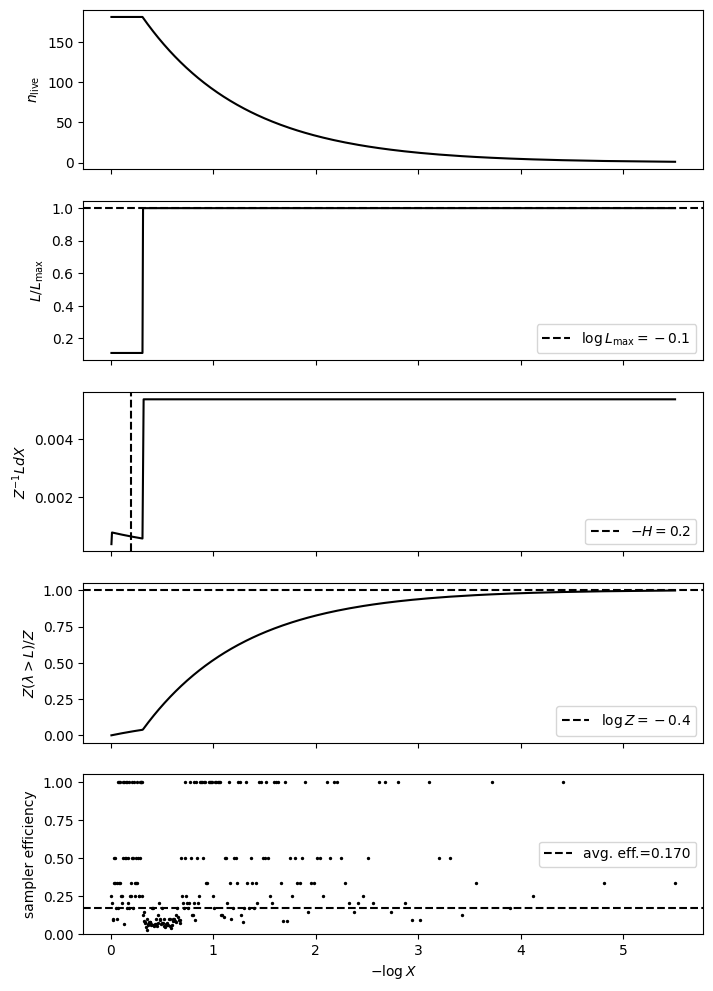

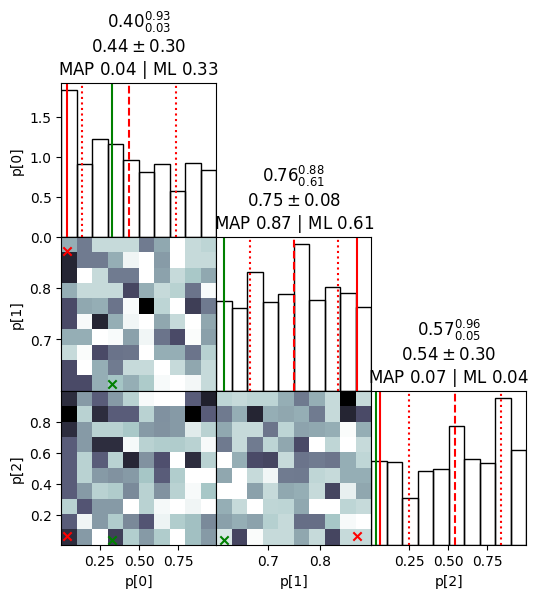

In [3]:
# Inspect results
ns.summary(results)
ns.plot_diagnostics(results)
ns.plot_cornerplot(results)